In [47]:
import glob
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import joblib

In [48]:
# Step 1: Define the folder path containing your CSV files
folder_path = "Dataset"

# Step 2: Find all CSV files in that folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# 3. Create a list to hold all DataFrames
dfs = []

# 4. Loop through the files and read them
for file in csv_files:
    df = pd.read_csv(file)
    dfs.append(df)
    
# 5. Merge all CSVs into a single DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# 6. Display first few rows to confirm merge
display(merged_df.head())

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


### Data Inspection

In [49]:
merged_df.info()
merged_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 991847 entries, 0 to 991846
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             991847 non-null  int64  
 1    Flow Duration                991847 non-null  int64  
 2    Total Fwd Packets            991847 non-null  int64  
 3    Total Backward Packets       991847 non-null  int64  
 4   Total Length of Fwd Packets   991847 non-null  int64  
 5    Total Length of Bwd Packets  991847 non-null  int64  
 6    Fwd Packet Length Max        991847 non-null  int64  
 7    Fwd Packet Length Min        991847 non-null  int64  
 8    Fwd Packet Length Mean       991847 non-null  float64
 9    Fwd Packet Length Std        991847 non-null  float64
 10  Bwd Packet Length Max         991847 non-null  int64  
 11   Bwd Packet Length Min        991847 non-null  int64  
 12   Bwd Packet Length Mean       991847 non-nul

/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,991847.000000,9.918470e+05,991847.000000,991847.000000,9.918470e+05,9.918470e+05,991847.000000,991847.000000,991847.000000,991847.000000,...,991847.000000,9.918470e+05,9.918470e+05,9.918470e+05,9.918470e+05,9.918470e+05,9.918470e+05,9.918470e+05,9.918470e+05,991847
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BENIGN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,702888
mean,8029.460123,1.010447e+07,6.588429,7.029223,5.615418e+02,9.398725e+03,220.609470,18.932977,66.604021,77.534908,...,25.689125,8.632732e+04,3.202734e+04,1.437475e+05,6.855121e+04,4.325971e+06,9.086962e+05,4.972432e+06,3.653136e+06,NaN
std,17337.595923,2.798268e+07,483.627389,652.479883,1.459708e+04,1.458638e+06,983.501776,83.197222,263.604144,405.969188,...,6.903244,6.591466e+05,3.442482e+05,9.669962e+05,6.031284e+05,1.456104e+07,6.427007e+06,1.676458e+07,1.358547e+07,NaN
min,0.000000,-1.300000e+01,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,53.000000,6.500000e+01,1.000000,1.000000,4.000000e+00,6.000000e+00,2.000000,0.000000,2.000000,0.000000,...,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
50%,109.000000,2.382800e+04,2.000000,2.000000,3.500000e+01,6.200000e+01,20.000000,2.000000,8.666667,0.000000,...,24.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
75%,3301.000000,1.102699e+06,3.000000,3.000000,8.400000e+01,2.970000e+02,46.000000,32.000000,43.428571,5.740416,...,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN


In [50]:
# labels in data
print(merged_df[' Label'].unique())

['BENIGN' 'PortScan' 'Infiltration' 'Bot' 'DDoS']


### Check for null and Infinity values in Columns and drop rows with null values

In [51]:
# find out which many null values exist per feature/column
for col in merged_df.columns:
    has_null = merged_df[col].isnull().any()   # Returns True if column has at least one null
    if has_null:
        print(f"{col}: {has_null}")

Flow Bytes/s: True


In [52]:
# drop rows with null values
merged_df.dropna(inplace=True)

In [53]:
# Make a copy to avoid modifying the original DataFrame accidentally
df = merged_df.copy()

# Identify numeric columns only (skip non-numerical ones like label)
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Check for infinite values (only in numeric columns)
inf_counts = np.isinf(df[numeric_cols]).sum()

# Display only columns that contain infinity
inf_columns = inf_counts[inf_counts > 0]

if not inf_columns.empty:
    print("Columns containing infinity values:")
    for col, count in inf_columns.items():
        print(f" - {col}: {count} infinite values")
else:
    print("No infinite values found in numeric columns.")

# Drop rows that contain any infinity values (across all numeric columns)
rows_before = len(df)
df = df[~np.isinf(df[numeric_cols]).any(axis=1)].copy()
rows_after = len(df)

print(f"Rows with infinity values removed: {rows_before - rows_after}")
print(f"Remaining rows: {rows_after}")

# Replace the original DataFrame if desired
merged_df = df


Columns containing infinity values:
 - Flow Bytes/s: 669 infinite values
 -  Flow Packets/s: 669 infinite values
Rows with infinity values removed: 669
Remaining rows: 991113


In [54]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 991113 entries, 0 to 991846
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             991113 non-null  int64  
 1    Flow Duration                991113 non-null  int64  
 2    Total Fwd Packets            991113 non-null  int64  
 3    Total Backward Packets       991113 non-null  int64  
 4   Total Length of Fwd Packets   991113 non-null  int64  
 5    Total Length of Bwd Packets  991113 non-null  int64  
 6    Fwd Packet Length Max        991113 non-null  int64  
 7    Fwd Packet Length Min        991113 non-null  int64  
 8    Fwd Packet Length Mean       991113 non-null  float64
 9    Fwd Packet Length Std        991113 non-null  float64
 10  Bwd Packet Length Max         991113 non-null  int64  
 11   Bwd Packet Length Min        991113 non-null  int64  
 12   Bwd Packet Length Mean       991113 non-null  fl

### Check and remove duplicates

In [55]:
merged_df.duplicated().sum()
merged_df.drop_duplicates(inplace=True)

In [56]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 861328 entries, 0 to 991846
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             861328 non-null  int64  
 1    Flow Duration                861328 non-null  int64  
 2    Total Fwd Packets            861328 non-null  int64  
 3    Total Backward Packets       861328 non-null  int64  
 4   Total Length of Fwd Packets   861328 non-null  int64  
 5    Total Length of Bwd Packets  861328 non-null  int64  
 6    Fwd Packet Length Max        861328 non-null  int64  
 7    Fwd Packet Length Min        861328 non-null  int64  
 8    Fwd Packet Length Mean       861328 non-null  float64
 9    Fwd Packet Length Std        861328 non-null  float64
 10  Bwd Packet Length Max         861328 non-null  int64  
 11   Bwd Packet Length Min        861328 non-null  int64  
 12   Bwd Packet Length Mean       861328 non-null  fl

## Train/Test Split, Feature Selection, Scaling,Training and Evaluation

In [57]:
print(merged_df.columns.tolist())

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [58]:
# Separate label (target) and features
X = merged_df.drop(' Label', axis=1)  # all columns except label
y = (df[" Label"] != "BENIGN").astype(int)  # e.g., make malicious=1 if label not benign

In [59]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [60]:
# scale only the training set in order to avoid label leakage
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

### Feature Selection

In [61]:
# Feature selection (top 20)
selector = SelectKBest(score_func=f_classif, k=20)
X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel  = selector.transform(X_test_scaled)
selected_features = X_train.columns[selector.get_support()]

print("Selected features:", selected_features)

/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [31 33 56 57 58 59 60 61] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/passwd/DDoS_Detection/venv/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:111: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Selected features: Index([' Destination Port', ' Fwd Packet Length Max',
       ' Fwd Packet Length Mean', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', ' Fwd IAT Std', 'Bwd IAT Total',
       ' Bwd IAT Max', ' Min Packet Length', ' Max Packet Length',
       ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance',
       ' PSH Flag Count', ' URG Flag Count', ' Average Packet Size',
       ' Avg Fwd Segment Size', ' Avg Bwd Segment Size'],
      dtype='object')


### Train logistic regression

In [62]:
clf_lr = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf_lr.fit(X_train_sel, y_train)
y_pred_lr  = clf_lr.predict(X_test_sel)
y_proba_lr = clf_lr.predict_proba(X_test_sel)[:,1]

In [63]:
print("Logistic Regression results:")
print(classification_report(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_proba_lr))

Logistic Regression results:
              precision    recall  f1-score   support

           0       1.00      0.86      0.92    192191
           1       0.70      0.99      0.82     66208

    accuracy                           0.89    258399
   macro avg       0.85      0.92      0.87    258399
weighted avg       0.92      0.89      0.90    258399

ROC AUC: 0.9565602490662867


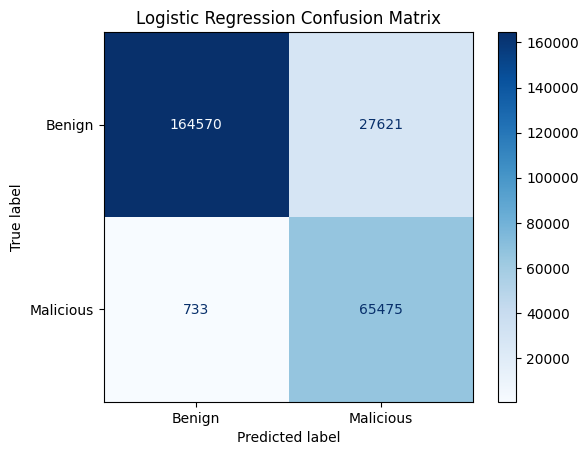

In [64]:
# Confusion Matrix (Logistic Regression)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Benign", "Malicious"])
disp_lr.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [65]:
# Save Logistic Regression Model
joblib.dump(clf_lr, "logistic_regression_model.joblib")
joblib.dump(scaler, "minmax_scaler.joblib")
joblib.dump(selector, "feature_selector.joblib")

['feature_selector.joblib']

### Train Decision Tree

In [66]:
clf_dt = DecisionTreeClassifier(max_depth=10, class_weight="balanced", random_state=42)
clf_dt.fit(X_train_sel, y_train)
y_pred_dt = clf_dt.predict(X_test_sel)

In [67]:
print("Decision Tree results:")
print(classification_report(y_test, y_pred_dt))

Decision Tree results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192191
           1       0.99      1.00      0.99     66208

    accuracy                           1.00    258399
   macro avg       0.99      1.00      0.99    258399
weighted avg       1.00      1.00      1.00    258399



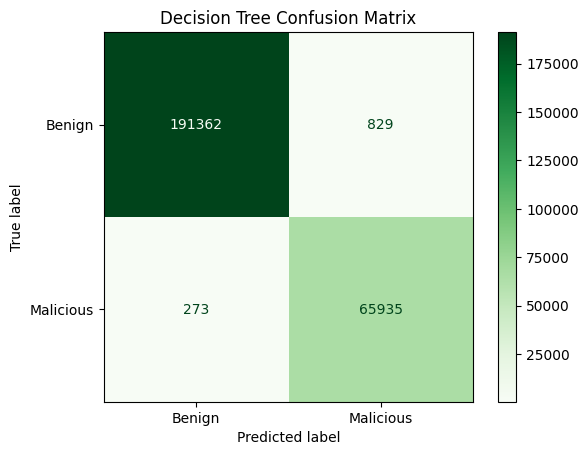

In [68]:
# Confusion Matrix (Decision Tree)
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Benign", "Malicious"])
disp_dt.plot(cmap='Greens', values_format='d')
plt.title("Decision Tree Confusion Matrix")
plt.show()

In [69]:
# Save Decision Tree Model
joblib.dump(clf_dt, "decision_tree_model.joblib")
print("Decision Tree model saved as 'decision_tree_model.joblib'")

Decision Tree model saved as 'decision_tree_model.joblib'


### Interpretation

In [70]:
# Logistic coefficients
for feat, coef in zip(selected_features, clf_lr.coef_[0]):
    print(feat, ":", coef)

 Destination Port : -1.8356895371355928
 Fwd Packet Length Max : -47.067278771766894
 Fwd Packet Length Mean : -47.408310027286554
Bwd Packet Length Max : -10.136573459433947
 Bwd Packet Length Min : -53.19808693962899
 Bwd Packet Length Mean : -6.9709928170733875
 Bwd Packet Length Std : 0.300162479309854
 Fwd IAT Std : 16.09768863464665
Bwd IAT Total : -18.46328580981351
 Bwd IAT Max : 8.152913291864856
 Min Packet Length : -29.15091949922446
 Max Packet Length : -14.13205692954877
 Packet Length Mean : 0.8452829152774215
 Packet Length Std : 0.2943500536059849
 Packet Length Variance : 75.88141277623134
 PSH Flag Count : 1.3737699411780844
 URG Flag Count : -2.9996789000318635
 Average Packet Size : 5.7064732294699025
 Avg Fwd Segment Size : -47.408310027286554
 Avg Bwd Segment Size : -6.9709928170595195


In [71]:
# Tree feature importances
for feat, imp in zip(selected_features, clf_dt.feature_importances_):
    print(feat, ":", imp)

 Destination Port : 0.012033037027053776
 Fwd Packet Length Max : 0.5552983401392941
 Fwd Packet Length Mean : 0.00023035174581054982
Bwd Packet Length Max : 0.0
 Bwd Packet Length Min : 0.0007028796775910621
 Bwd Packet Length Mean : 8.490167405906107e-05
 Bwd Packet Length Std : 0.0002369565731144856
 Fwd IAT Std : 0.20626853983376156
Bwd IAT Total : 0.0010580907808735477
 Bwd IAT Max : 0.0002361607224930512
 Min Packet Length : 0.0026220728367945694
 Max Packet Length : 0.0007196748209741894
 Packet Length Mean : 0.0028288640631458483
 Packet Length Std : 0.00018665060177676932
 Packet Length Variance : 0.16105094781901994
 PSH Flag Count : 0.000766467891867379
 URG Flag Count : 0.0010645542579834
 Average Packet Size : 0.018373355560393684
 Avg Fwd Segment Size : 0.00017104306694748635
 Avg Bwd Segment Size : 0.03606711090704554
